In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind

In [91]:
df = pd.read_csv('/Users/igor/Downloads/data.csv', sep=',', encoding='utf-8')

df['Metro station'] = df['Metro station'].str.strip()

# Преобразование категориальных переменных в dummy-переменные
df_encoded = pd.get_dummies(df, columns=['Apartment type', 'Region', 'Renovation'], drop_first=True)

# Убираем выбросы
df_cleaned = df_encoded[(df_encoded['Price'] < 1e9) & (df_encoded['Area'] < 500)]


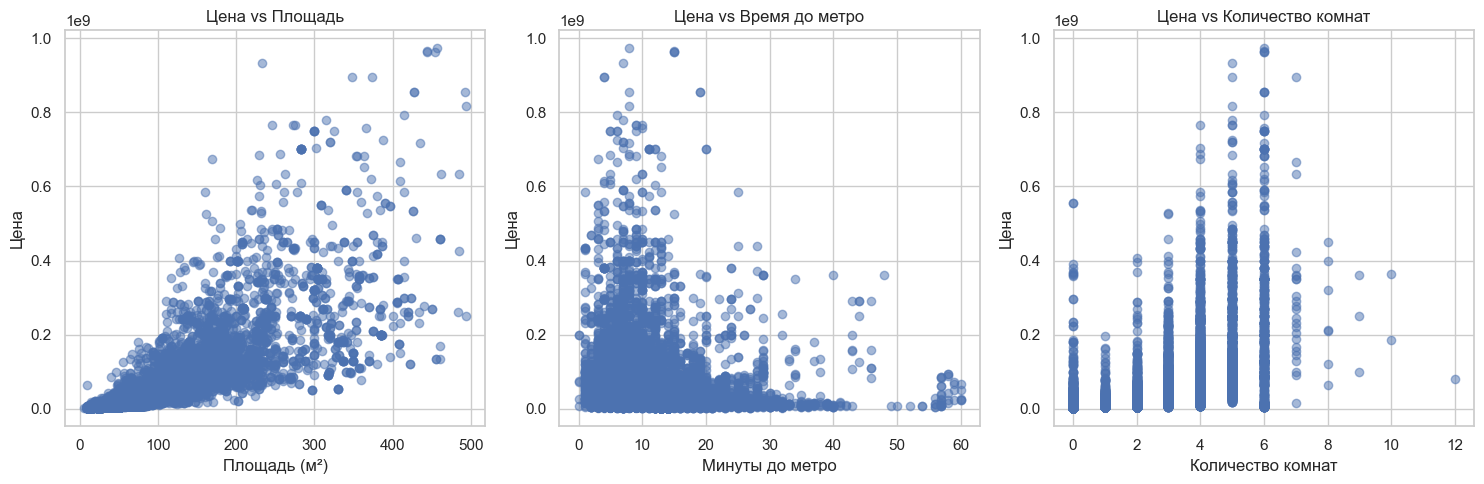

In [92]:
# Графики зависимости
plt.figure(figsize=(15, 5))

# Цена от площади
plt.subplot(1, 3, 1)
plt.scatter(df_cleaned['Area'], df_cleaned['Price'], alpha=0.5)
plt.xlabel('Площадь (м²)')
plt.ylabel('Цена')
plt.title('Цена vs Площадь')

# Цена от времени до метро
plt.subplot(1, 3, 2)
plt.scatter(df_cleaned['Minutes to metro'], df_cleaned['Price'], alpha=0.5)
plt.xlabel('Минуты до метро')
plt.ylabel('Цена')
plt.title('Цена vs Время до метро')

# Цена от количества комнат
plt.subplot(1, 3, 3)
plt.scatter(df_cleaned['Number of rooms'], df_cleaned['Price'], alpha=0.5)
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Цена vs Количество комнат')

plt.tight_layout()
plt.show()

In [93]:
# Определяем X и y без Living area и Kitchen area
X = df_cleaned[['Minutes to metro', 'Number of rooms', 'Area', 'Floor', 'Number of floors',
                'Apartment type_Secondary', 'Region_Moscow region', 'Renovation_Designer',
                'Renovation_European-style renovation', 'Renovation_Without renovation']]
y = df_cleaned['Price']

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Оцениваем
y_pred = model.predict(X_test)
print("R² на тестовой выборке:", r2_score(y_test, y_pred))

# Коэффициенты
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nКоэффициенты модели:")
print(coefficients)

R² на тестовой выборке: 0.6613352954653837

Коэффициенты модели:
                                       Coefficient
Minutes to metro                     -4.065880e+05
Number of rooms                      -6.848141e+06
Area                                  1.023639e+06
Floor                                -8.866869e+04
Number of floors                     -4.266398e+05
Apartment type_Secondary              1.119074e+07
Region_Moscow region                 -1.572783e+04
Renovation_Designer                   2.020907e+07
Renovation_European-style renovation -3.449611e+06
Renovation_Without renovation         2.104189e+06


In [95]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("R² Random Forest:", r2_score(y_test, y_pred_rf))

R² Random Forest: 0.7925680304823296


In [96]:
# Важность признаков
importances = pd.DataFrame(model_rf.feature_importances_, X.columns, columns=['Importance'])
print("\nВажность признаков в Random Forest:")
print(importances.sort_values(by='Importance', ascending=False))


Важность признаков в Random Forest:
                                      Importance
Area                                    0.766682
Number of floors                        0.089101
Minutes to metro                        0.046510
Floor                                   0.044183
Number of rooms                         0.022803
Renovation_Designer                     0.016842
Renovation_Without renovation           0.005640
Apartment type_Secondary                0.004802
Renovation_European-style renovation    0.002654
Region_Moscow region                    0.000783


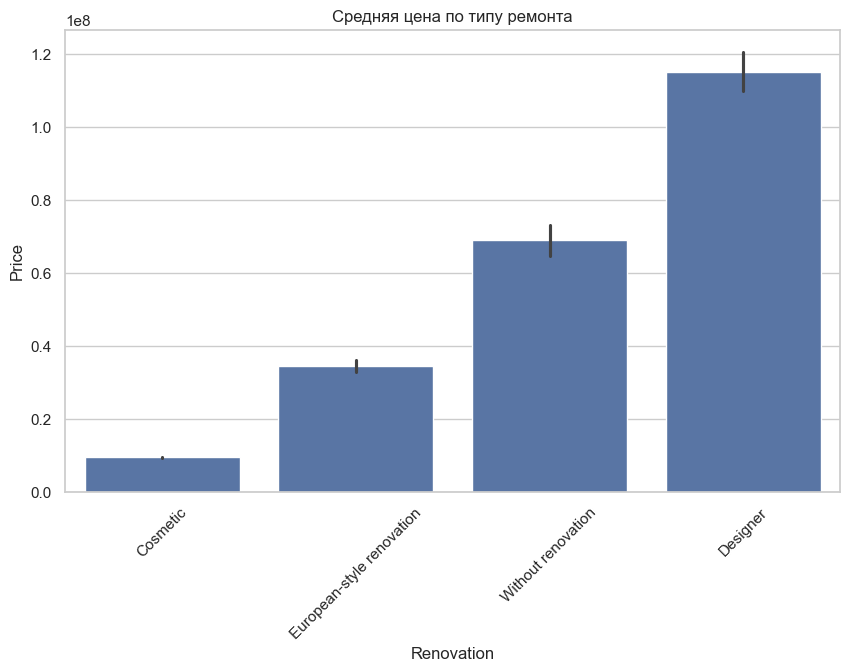

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Renovation', y='Price', data=df)
plt.title('Средняя цена по типу ремонта')
plt.xticks(rotation=45)
plt.show()

In [99]:
# Частотность по Apartment type
print("Частотность по типу квартиры:")
print(df['Apartment type'].value_counts())

# Частотность по Number of rooms
print("\nЧастотность по количеству комнат:")
print(df['Number of rooms'].value_counts().sort_index())

Частотность по типу квартиры:
Apartment type
Secondary       13152
New building     9524
Name: count, dtype: int64

Частотность по количеству комнат:
Number of rooms
0.0     3731
1.0     5141
2.0     6342
3.0     3814
4.0     1957
5.0      993
6.0      652
7.0       27
8.0       10
9.0        3
10.0       5
12.0       1
Name: count, dtype: int64


In [100]:
# Средние значения по Apartment type
print("\nСредняя цена и площадь по типу квартиры:")
print(df.groupby('Apartment type')[['Price', 'Area']].mean())

# Средние значения по Number of rooms
print("\nСредняя цена и площадь по количеству комнат:")
print(df.groupby('Number of rooms')[['Price', 'Area']].mean())


Средняя цена и площадь по типу квартиры:
                       Price       Area
Apartment type                         
New building    8.170584e+06  50.108303
Secondary       5.636180e+07  87.795642

Средняя цена и площадь по количеству комнат:
                        Price        Area
Number of rooms                          
0.0              1.365475e+07   33.420976
1.0              1.071188e+07   40.239518
2.0              1.475157e+07   56.187397
3.0              3.324977e+07   81.198797
4.0              9.243111e+07  134.754323
5.0              1.669053e+08  202.819537
6.0              2.023322e+08  233.911595
7.0              2.976285e+08  333.670370
8.0              2.680832e+08  392.120000
9.0              2.368000e+08  320.800000
10.0             5.297736e+08  507.400000
12.0             8.100000e+07  268.000000


In [101]:
# Добавляем столбец Price per m²
df['Price per m²'] = df['Price'] / df['Area']

# Средняя цена за м² по Apartment type
print("\nСредняя цена за м² по типу квартиры:")
print(df.groupby('Apartment type')['Price per m²'].mean())

# Средняя цена за м² по Number of rooms
print("\nСредняя цена за м² по количеству комнат:")
print(df.groupby('Number of rooms')['Price per m²'].mean())


Средняя цена за м² по типу квартиры:
Apartment type
New building    164327.547706
Secondary       478652.427981
Name: Price per m², dtype: float64

Средняя цена за м² по количеству комнат:
Number of rooms
0.0     306933.720072
1.0     260655.958637
2.0     247450.019468
3.0     358502.476048
4.0     603463.397559
5.0     762097.157579
6.0     708672.257762
7.0     876091.477590
8.0     753133.029100
9.0     732289.883427
10.0    990853.980436
12.0    302238.805970
Name: Price per m², dtype: float64


In [102]:
# Средние Living area и Kitchen area по Apartment type
print("\nСоотношение Living area и Kitchen area по типу квартиры:")
print(df.groupby('Apartment type')[['Living area', 'Kitchen area']].mean())

# Средние Living area и Kitchen area по Number of rooms
print("\nСоотношение Living area и Kitchen area по количеству комнат:")
print(df.groupby('Number of rooms')[['Living area', 'Kitchen area']].mean())


Соотношение Living area и Kitchen area по типу квартиры:
                Living area  Kitchen area
Apartment type                           
New building      26.210531     10.983515
Secondary         47.430353     13.760371

Соотношение Living area и Kitchen area по количеству комнат:
                 Living area  Kitchen area
Number of rooms                           
0.0                19.773814      8.251488
1.0                18.384614     11.684828
2.0                30.248880     11.081205
3.0                45.719586     12.669428
4.0                75.700409     17.824067
5.0               106.612790     24.605438
6.0               115.894325     23.555982
7.0               181.503704     31.681481
8.0               236.990000     31.720000
9.0               164.066667     29.833333
10.0              278.160000     35.340000
12.0              200.000000     15.000000


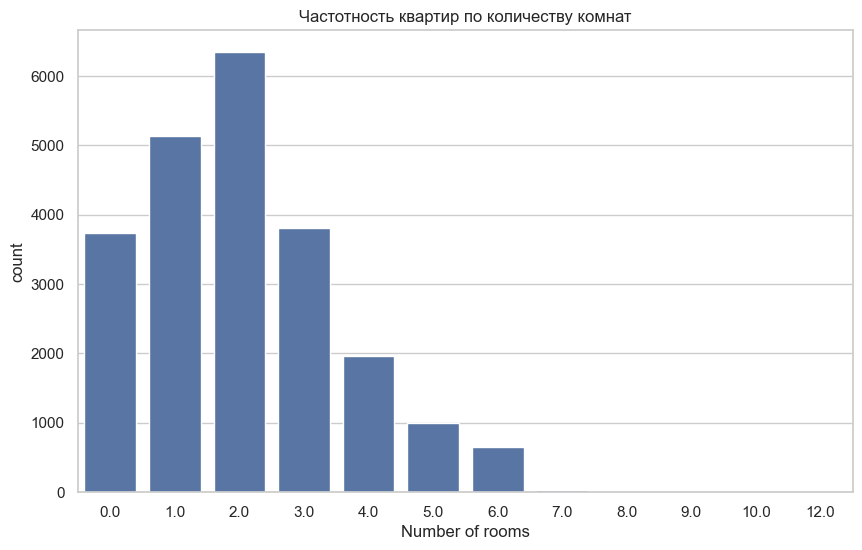

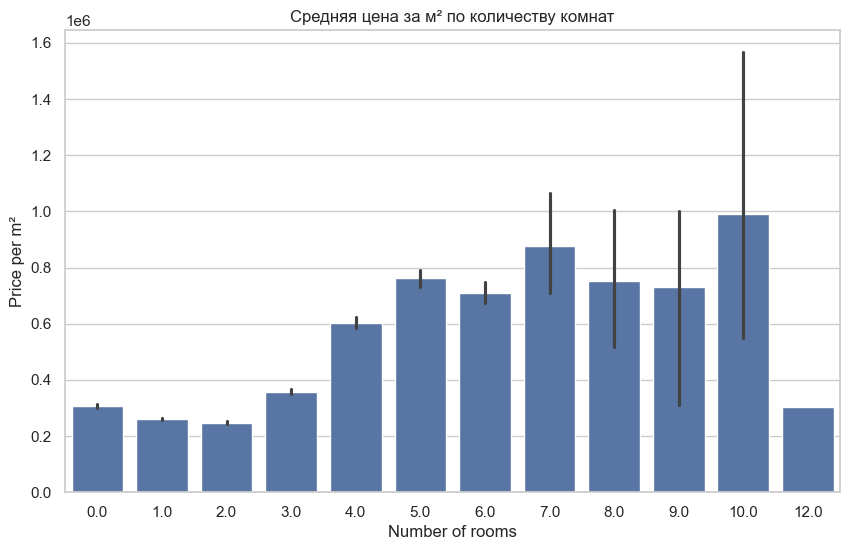

In [104]:
# Частотность Number of rooms
plt.figure(figsize=(10, 6))
sns.countplot(x='Number of rooms', data=df)
plt.title('Частотность квартир по количеству комнат')
plt.show()

# Средняя цена за м² по Number of rooms
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of rooms', y='Price per m²', data=df)
plt.title('Средняя цена за м² по количеству комнат')
plt.show()

In [109]:
# Группировка по Apartment type и Number of rooms
grouped = df.groupby(['Apartment type', 'Number of rooms'])[['Price', 'Area', 'Price per m²']].mean()

# Вывод результатов
print("Средние значения по типу квартиры и количеству комнат:")
print(grouped)

Средние значения по типу квартиры и количеству комнат:
                                       Price        Area   Price per m²
Apartment type Number of rooms                                         
New building   0.0              4.319160e+06   25.792543  168106.518928
               1.0              7.038181e+06   40.401438  174770.137333
               2.0              8.707611e+06   55.355375  156971.811863
               3.0              1.167534e+07   73.082253  159657.739440
               4.0              1.474980e+07   86.820824  165741.809856
               5.0              2.501467e+07  107.415714  232955.824023
Secondary      0.0              1.847239e+07   37.357631  378575.550813
               1.0              1.518594e+07   40.042321  365252.884238
               2.0              2.437841e+07   57.512645  391564.122832
               3.0              4.517896e+07   85.686690  468450.013635
               4.0              9.982106e+07  139.314309  645104.511106
         

In [113]:
# Группы по площади
bins = [0, 50, 100, 150, 200, 500, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '200-500', '500+']
df['Area_group'] = pd.cut(df['Area'], bins=bins, labels=labels)

# Средние значения по группам площади и типу квартиры
print("\nСредние значения по группам площади и типу квартиры:")
print(df.groupby(['Apartment type', 'Area_group'], observed=True)[['Price', 'Price per m²']].mean())


Средние значения по группам площади и типу квартиры:
                                  Price   Price per m²
Apartment type Area_group                             
New building   0-50        6.257065e+06  170431.035680
               50-100      1.021510e+07  156491.327257
               100-150     2.175272e+07  196270.719148
               150-200     2.478424e+07  149640.048141
               200-500     2.049000e+07  101185.185185
Secondary      0-50        1.118786e+07  352458.496572
               50-100      2.854556e+07  396022.732535
               100-150     7.657280e+07  616254.273843
               150-200     1.410117e+08  809790.187722
               200-500     2.602673e+08  932358.759370
               500+        5.899508e+08  968763.643429


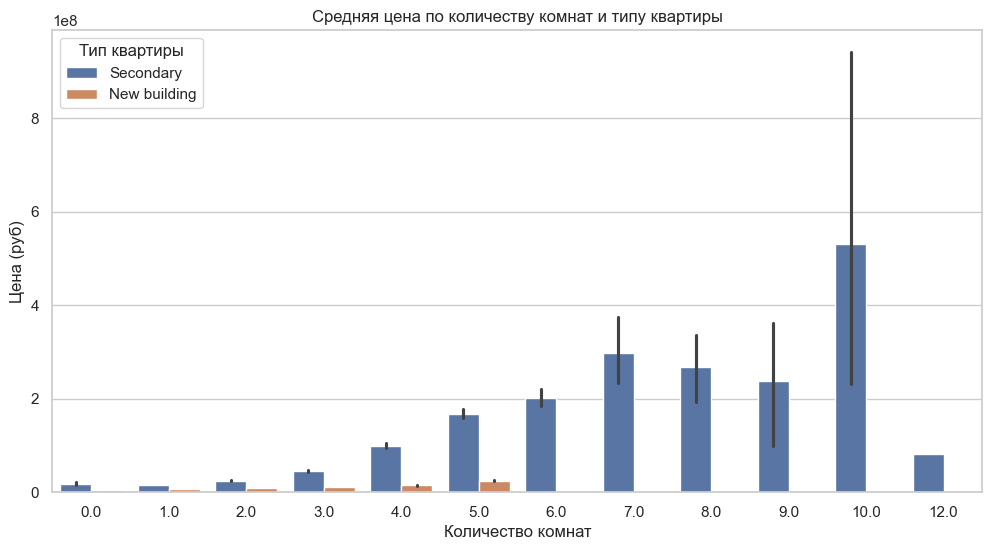

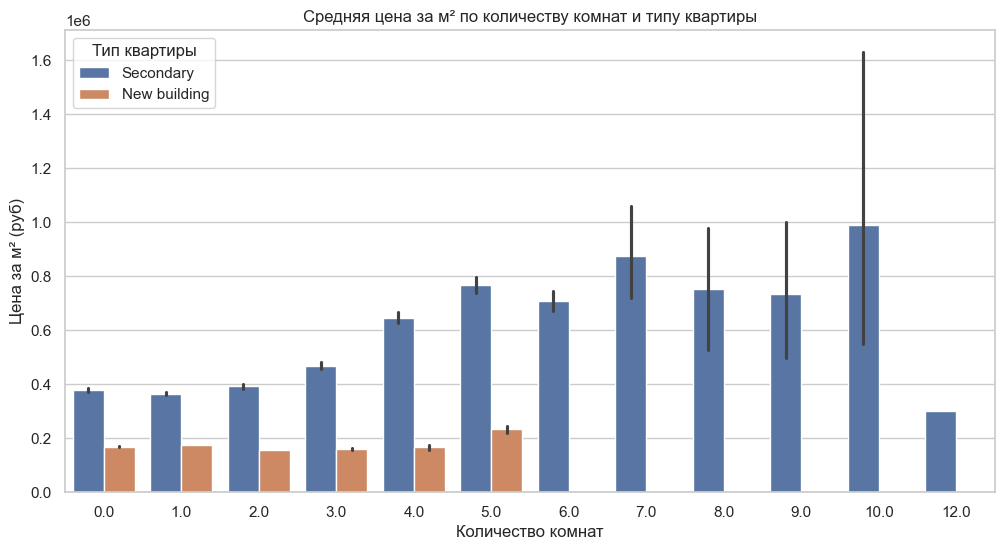

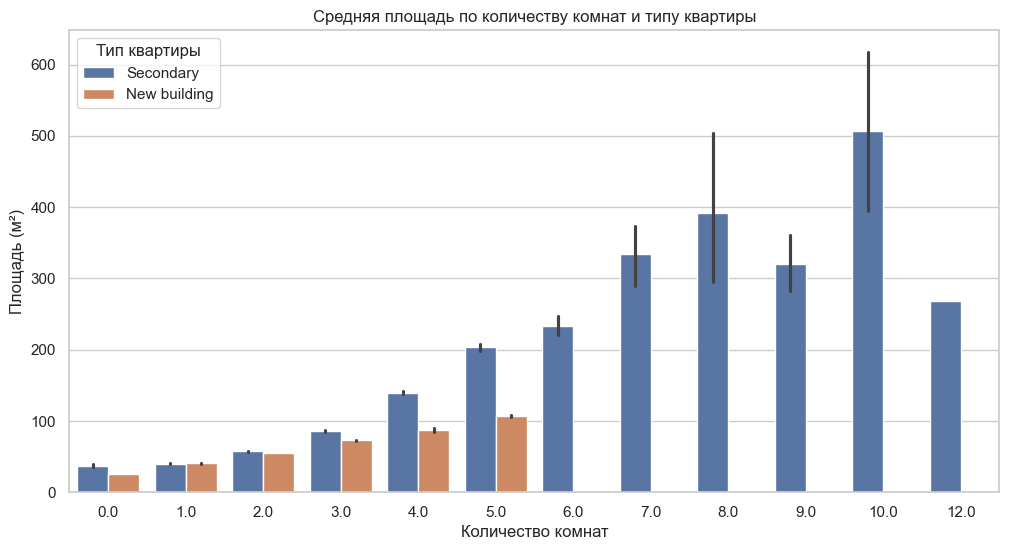

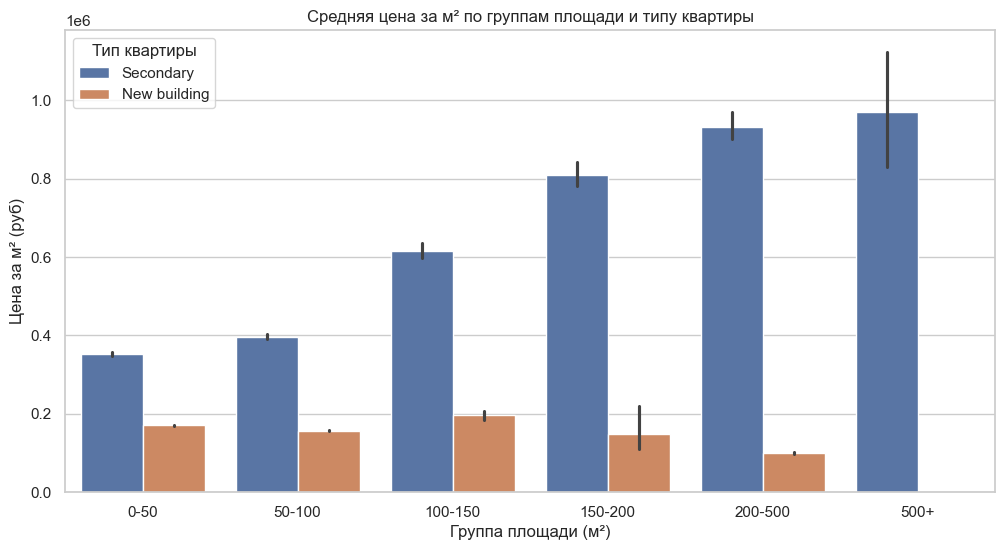

In [114]:
# Устанавливаем стиль
sns.set(style="whitegrid")

# 1. Средняя цена по количеству комнат
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of rooms', y='Price', hue='Apartment type', data=df)
plt.title('Средняя цена по количеству комнат и типу квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Цена (руб)')
plt.legend(title='Тип квартиры')
plt.show()

# 2. Средняя цена за м² по количеству комнат
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of rooms', y='Price per m²', hue='Apartment type', data=df)
plt.title('Средняя цена за м² по количеству комнат и типу квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за м² (руб)')
plt.legend(title='Тип квартиры')
plt.show()

# 3. Средняя площадь по количеству комнат
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of rooms', y='Area', hue='Apartment type', data=df)
plt.title('Средняя площадь по количеству комнат и типу квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Площадь (м²)')
plt.legend(title='Тип квартиры')
plt.show()

# 4. Средняя цена за м² по группам площади
plt.figure(figsize=(12, 6))
sns.barplot(x='Area_group', y='Price per m²', hue='Apartment type', data=df)
plt.title('Средняя цена за м² по группам площади и типу квартиры')
plt.xlabel('Группа площади (м²)')
plt.ylabel('Цена за м² (руб)')
plt.legend(title='Тип квартиры')
plt.show()

In [115]:
# Частотность по станциям метро и типу квартиры
station_counts = df.groupby(['Metro station', 'Apartment type']).size().unstack(fill_value=0)
station_counts['Total'] = station_counts['New building'] + station_counts['Secondary']

# Топ-10 станций по общему количеству квартир
print("Топ-10 станций по количеству квартир:")
print(station_counts.sort_values(by='Total', ascending=False).head(10))

Топ-10 станций по количеству квартир:
Apartment type     New building  Secondary  Total
Metro station                                    
Красногвардейская          2685         13   2698
Депо                       1623         24   1647
Братиславская              1108         53   1161
Котельники                  981          0    981
Жулебино                    719         12    731
Зябликово                   705         15    720
Битца                       359          1    360
Опалиха                       0        305    305
Каширская                   287          8    295
Домодедовская               217         55    272


In [116]:
# Фильтрация по выбранной станции (замени 'Тверская' на свою станцию)
station_name = 'Домодедовская'  # Подставь название после шага 1
df_station = df[df['Metro station'] == station_name]

# Средние значения по Apartment type и Number of rooms
grouped_station_rooms = df_station.groupby(['Apartment type', 'Number of rooms'])[['Price', 'Area', 'Price per m²']].mean()

print(f"Средние значения для станции {station_name} по количеству комнат:")
print(grouped_station_rooms)

Средние значения для станции Домодедовская по количеству комнат:
                                       Price        Area   Price per m²
Apartment type Number of rooms                                         
New building   0.0              4.885082e+06   26.088077  186180.768281
               1.0              6.184681e+06   36.966857  167807.016700
               2.0              8.879799e+06   54.324938  163596.656828
               3.0              1.130017e+07   75.650000  149366.453245
               4.0              1.147612e+07   77.385000  148299.522939
Secondary      0.0              5.408333e+06   17.208333  315513.376733
               1.0              1.190692e+07   37.361538  318430.449936
               2.0              1.518571e+07   51.507143  292732.117690
               3.0              1.746658e+07   63.066667  274960.435032
               4.0              2.123333e+07   81.366667  258850.059622
               6.0              3.450000e+07  145.000000  237931.034483

In [121]:
# Фильтрация по станции с явной копией
station_name = 'Домодедовская'  # Укажи нужную станцию, если не определена
df_station = df[df['Metro station'] == station_name].copy()

# Группы по площади
bins = [0, 50, 100, 150, 200, 500, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '200-500', '500+']
df_station['Area_group'] = pd.cut(df_station['Area'], bins=bins, labels=labels)

# Средние значения по Apartment type и Area_group с observed=True
grouped_station_area = df_station.groupby(['Apartment type', 'Area_group'], observed=True)[['Price', 'Price per m²']].mean()

print(f"\nСредние значения для станции {station_name} по группам площади:")
print(grouped_station_area)


Средние значения для станции Домодедовская по группам площади:
                                  Price   Price per m²
Apartment type Area_group                             
New building   0-50        6.046612e+06  172106.228644
               50-100      1.007969e+07  157938.654618
               100-150     1.210000e+07  119565.217391
Secondary      0-50        9.548125e+06  306939.267984
               50-100      1.818405e+07  285364.765518
               100-150     3.450000e+07  237931.034483


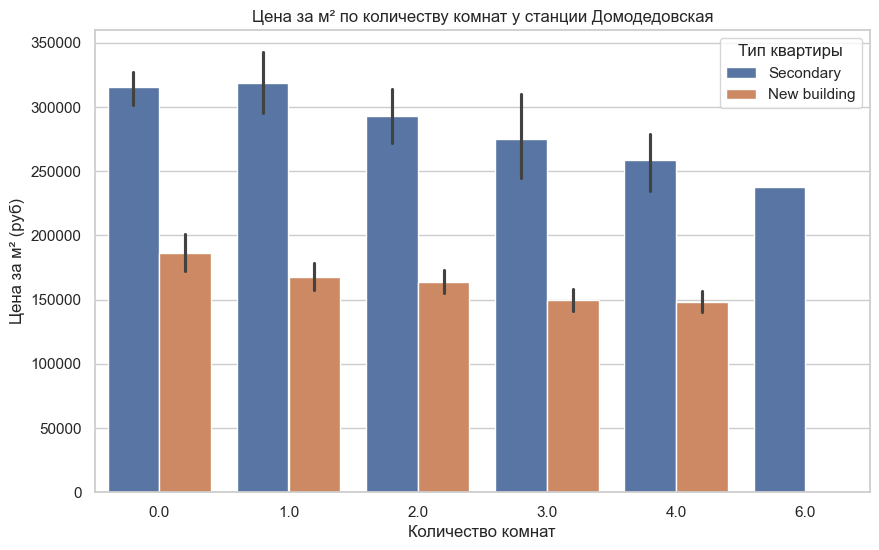

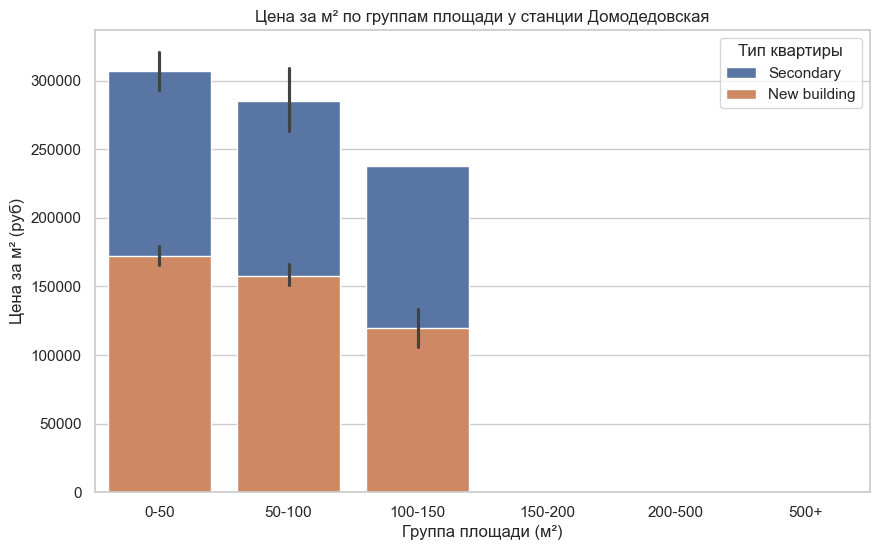

In [122]:
# Фильтрация по Домодедовской с явной копией
df_station = df[df['Metro station'] == 'Домодедовская'].copy()

# Цена за м² по количеству комнат
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of rooms', y='Price per m²', hue='Apartment type', data=df_station)
plt.title('Цена за м² по количеству комнат у станции Домодедовская')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за м² (руб)')
plt.legend(title='Тип квартиры')
plt.show()

# Цена за м² по группам площади
df_station.loc[:, 'Area_group'] = pd.cut(df_station['Area'],
                                         bins=[0, 50, 100, 150, 200, 500, float('inf')],
                                         labels=['0-50', '50-100', '100-150', '150-200', '200-500', '500+'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Area_group', y='Price per m²', hue='Apartment type', data=df_station)
plt.title('Цена за м² по группам площади у станции Домодедовская')
plt.xlabel('Группа площади (м²)')
plt.ylabel('Цена за м² (руб)')
plt.legend(title='Тип квартиры')
plt.show()

In [124]:
# Средние значения по этажу
floor_analysis = df.groupby('Floor')[['Price', 'Price per m²']].mean()
print("Средние значения по этажу (Floor):")
print(floor_analysis)

# Средние значения по этажности дома
floors_analysis = df.groupby('Number of floors')[['Price', 'Price per m²']].mean()
print("\nСредние значения по этажности дома (Number of floors):")
print(floors_analysis)

Средние значения по этажу (Floor):
              Price  Price per m²
Floor                            
1.0    2.945706e+07  3.317133e+05
2.0    3.651605e+07  3.737655e+05
3.0    4.562476e+07  4.176472e+05
4.0    5.046512e+07  4.194328e+05
5.0    4.792236e+07  3.965482e+05
...             ...           ...
75.0   1.443188e+08  7.074018e+05
77.0   1.033962e+08  7.773786e+05
79.0   3.500000e+08  1.186441e+06
82.0   2.893750e+08  8.182740e+05
92.0   2.646000e+08  9.800000e+05

[72 rows x 2 columns]

Средние значения по этажности дома (Number of floors):
                         Price   Price per m²
Number of floors                             
1                 1.118900e+08  576653.218550
2                 5.304904e+07  401470.306385
3                 9.333799e+07  514050.320102
4                 6.782089e+07  544179.218420
5                 5.800328e+07  473847.879916
...                        ...            ...
86                1.150000e+08  676470.588235
88                1.693333e+08

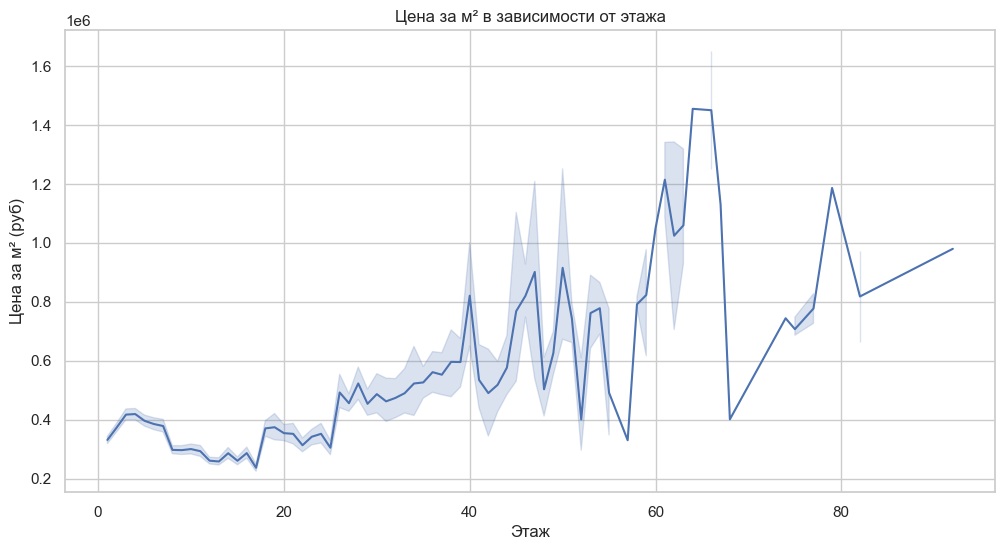

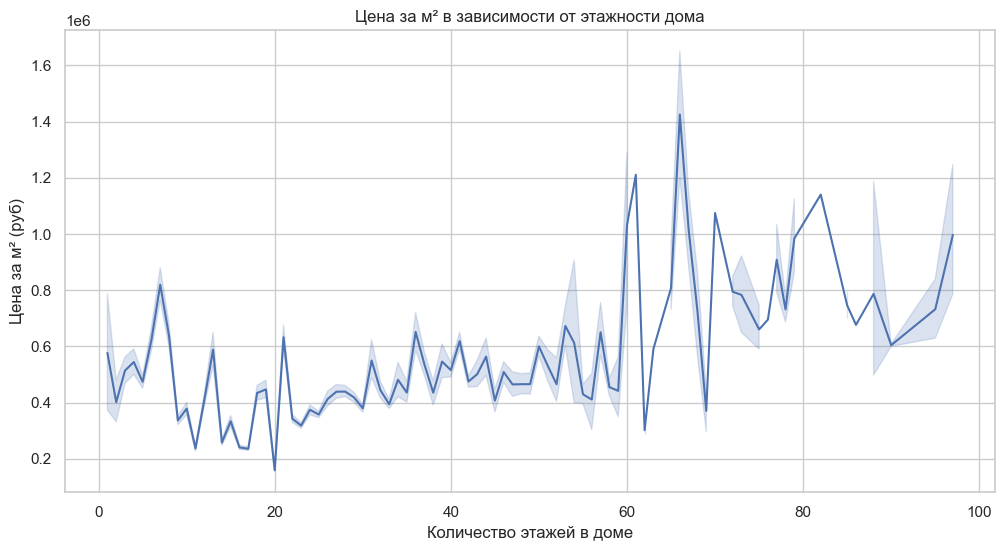

In [125]:
# Цена за м² по этажу
plt.figure(figsize=(12, 6))
sns.lineplot(x='Floor', y='Price per m²', data=df)
plt.title('Цена за м² в зависимости от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена за м² (руб)')
plt.show()

# Цена за м² по этажности дома
plt.figure(figsize=(12, 6))
sns.lineplot(x='Number of floors', y='Price per m²', data=df)
plt.title('Цена за м² в зависимости от этажности дома')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Цена за м² (руб)')
plt.show()

In [126]:
# Средние значения по типу ремонта
renovation_analysis = df.groupby('Renovation')[['Price', 'Price per m²', 'Area']].mean()
print("Средние значения по типу ремонта (Renovation):")
print(renovation_analysis)

Средние значения по типу ремонта (Renovation):
                                  Price   Price per m²        Area
Renovation                                                        
Cosmetic                   9.634695e+06  200212.719265   48.704268
Designer                   1.152157e+08  728899.620486  133.634812
European-style renovation  3.450900e+07  398456.843573   73.312490
Without renovation         6.909202e+07  511268.543562  105.132686


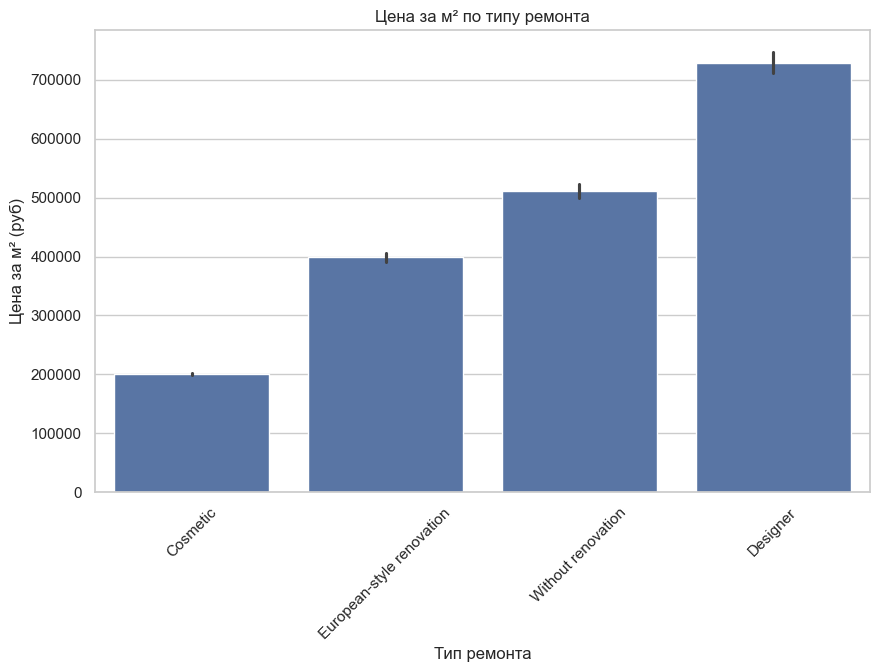

In [127]:
# Цена за м² по типу ремонта
plt.figure(figsize=(10, 6))
sns.barplot(x='Renovation', y='Price per m²', data=df)
plt.title('Цена за м² по типу ремонта')
plt.xlabel('Тип ремонта')
plt.ylabel('Цена за м² (руб)')
plt.xticks(rotation=45)
plt.show()

Средние значения по типу ремонта и этажности дома:
                                            Price   Price per m²
Renovation         Number of floors                             
Cosmetic           1                 9.900000e+06  170984.455959
                   2                 5.557143e+06  268745.111800
                   3                 1.363486e+07  393295.288895
                   4                 2.519175e+07  345148.790788
                   5                 1.597322e+07  304280.403003
...                                           ...            ...
Without renovation 78                5.600000e+07  777777.777778
                   79                6.240000e+07  751807.228916
                   85                5.545139e+07  668212.500641
                   95                3.287500e+08  692383.305217
                   97                1.340000e+08  744444.444444

[265 rows x 2 columns]


<Figure size 1200x600 with 0 Axes>

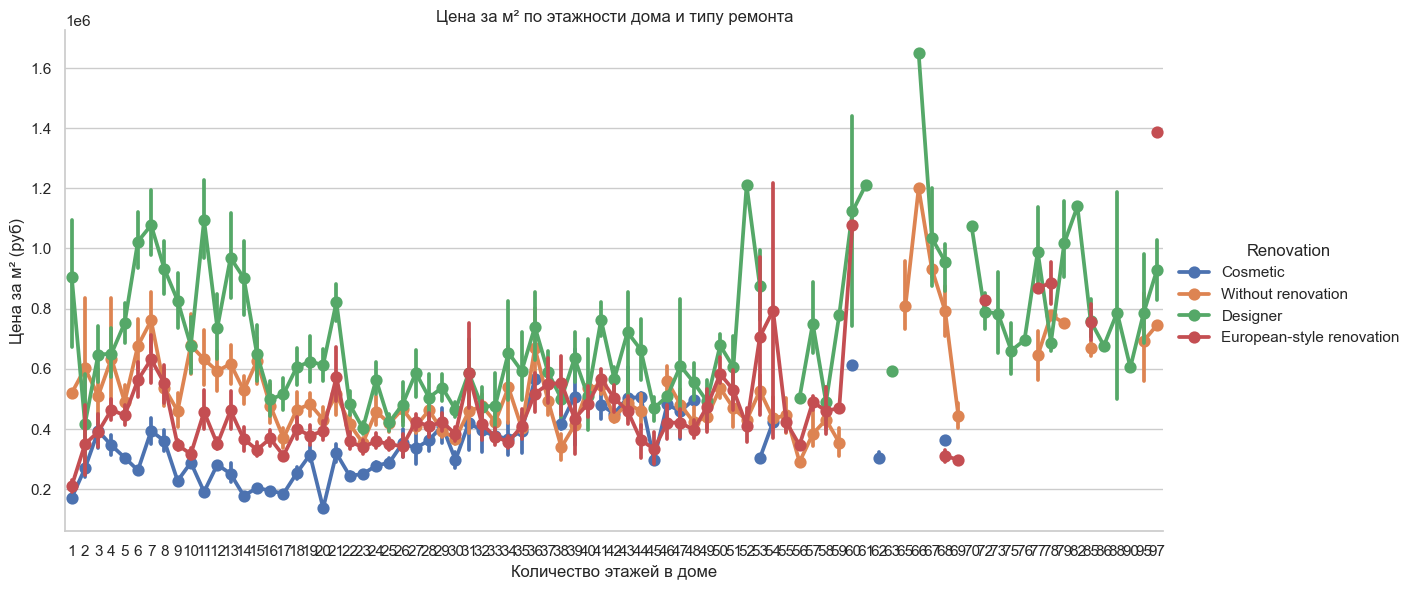

In [128]:
    # Группировка по ремонту и этажности
renovation_floors = df.groupby(['Renovation', 'Number of floors'])[['Price', 'Price per m²']].mean()
print("Средние значения по типу ремонта и этажности дома:")
print(renovation_floors)

# Визуализация взаимодействия
plt.figure(figsize=(12, 6))
sns.catplot(x='Number of floors', y='Price per m²', hue='Renovation', kind='point', data=df, height=6, aspect=2)
plt.title('Цена за м² по этажности дома и типу ремонта')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Цена за м² (руб)')
plt.show()

In [129]:
# Средние значения по регионам
region_analysis = df.groupby('Region')[['Price', 'Price per m²', 'Area', 'Number of rooms']].mean()
print("Средние значения по регионам:")
print(region_analysis)

# Частотность по регионам
region_counts = df['Region'].value_counts()
print("\nЧастотность по регионам:")
print(region_counts)

Средние значения по регионам:
                      Price   Price per m²       Area  Number of rooms
Region                                                                
Moscow         4.798348e+07  426503.269388  81.922181         2.222057
Moscow region  6.998220e+06  150547.785694  47.525167         1.603840

Частотность по регионам:
Region
Moscow           16113
Moscow region     6563
Name: count, dtype: int64


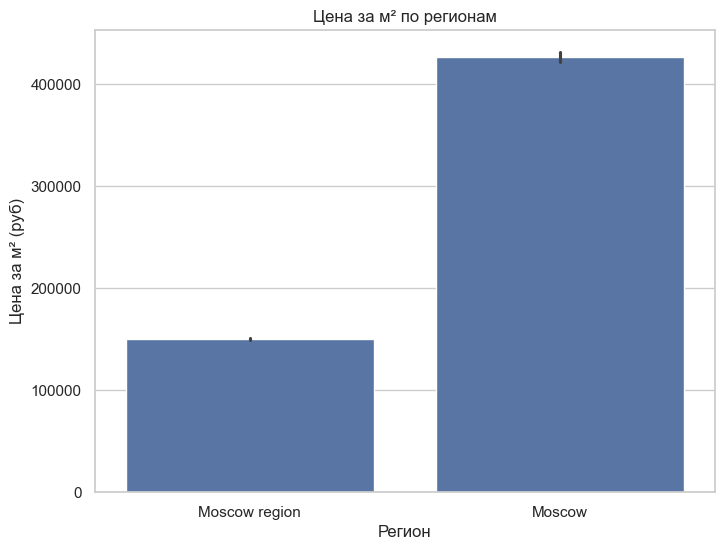

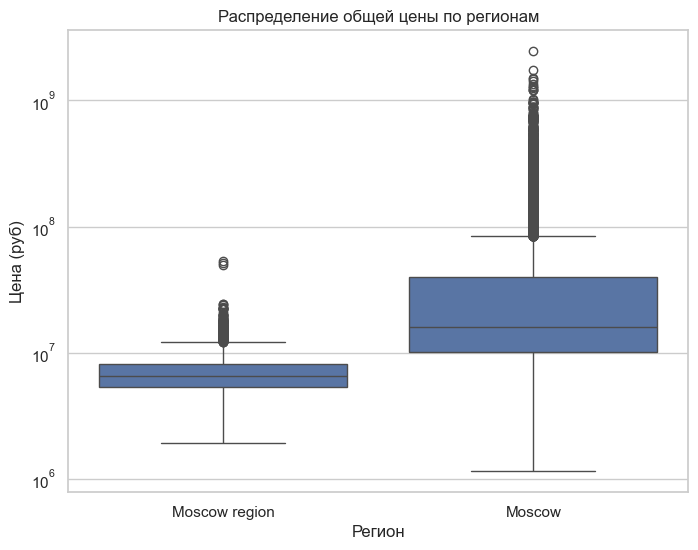

In [130]:
# Цена за м² по регионам
plt.figure(figsize=(8, 6))
sns.barplot(x='Region', y='Price per m²', data=df)
plt.title('Цена за м² по регионам')
plt.xlabel('Регион')
plt.ylabel('Цена за м² (руб)')
plt.show()

# Распределение общей цены по регионам
plt.figure(figsize=(8, 6))
sns.boxplot(x='Region', y='Price', data=df)
plt.title('Распределение общей цены по регионам')
plt.xlabel('Регион')
plt.ylabel('Цена (руб)')
plt.yscale('log')  # Логарифмическая шкала для лучшей видимости
plt.show()

In [131]:
# Средние значения по регионам и количеству комнат
region_rooms = df.groupby(['Region', 'Number of rooms'])[['Price', 'Price per m²', 'Area']].mean()
print("Средние значения по регионам и количеству комнат:")
print(region_rooms)

Средние значения по регионам и количеству комнат:
                                      Price   Price per m²        Area
Region        Number of rooms                                         
Moscow        0.0              1.701572e+07  360374.822530   36.144581
              1.0              1.303437e+07  312689.966274   40.708840
              2.0              2.037720e+07  326521.932782   59.522468
              3.0              4.090449e+07  429241.483898   84.946692
              4.0              9.646289e+07  627067.011120  137.364137
              5.0              1.669053e+08  762097.157579  202.819537
              6.0              2.023322e+08  708672.257762  233.911595
              7.0              2.976285e+08  876091.477590  333.670370
              8.0              2.680832e+08  753133.029100  392.120000
              9.0              2.368000e+08  732289.883427  320.800000
              10.0             5.297736e+08  990853.980436  507.400000
              12.0         

In [132]:
# Средние значения по регионам и типу ремонта
region_renovation = df.groupby(['Region', 'Renovation'])[['Price', 'Price per m²', 'Area']].mean()
print("\nСредние значения по регионам и типу ремонта:")
print(region_renovation)


Средние значения по регионам и типу ремонта:
                                                Price   Price per m²  \
Region        Renovation                                               
Moscow        Cosmetic                   1.239208e+07  251516.229343   
              Designer                   1.169625e+08  736665.575298   
              European-style renovation  3.546981e+07  406286.751790   
              Without renovation         6.977823e+07  514971.009165   
Moscow region Cosmetic                   6.818027e+06  147806.256710   
              Designer                   1.338859e+07  276190.137003   
              European-style renovation  1.198763e+07  214923.794970   
              Without renovation         8.819968e+06  186068.648040   

                                               Area  
Region        Renovation                             
Moscow        Cosmetic                    50.133316  
              Designer                   135.131332  
              Eur

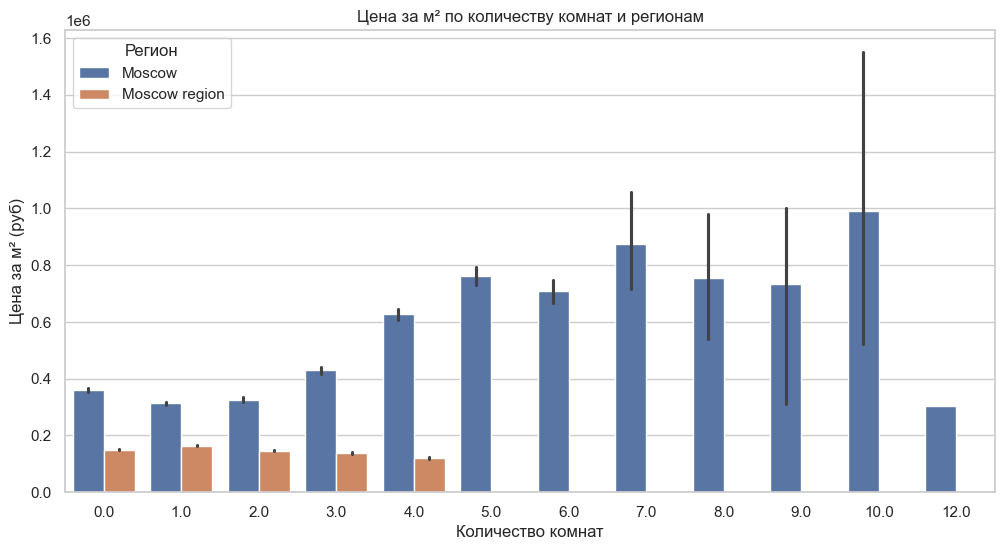

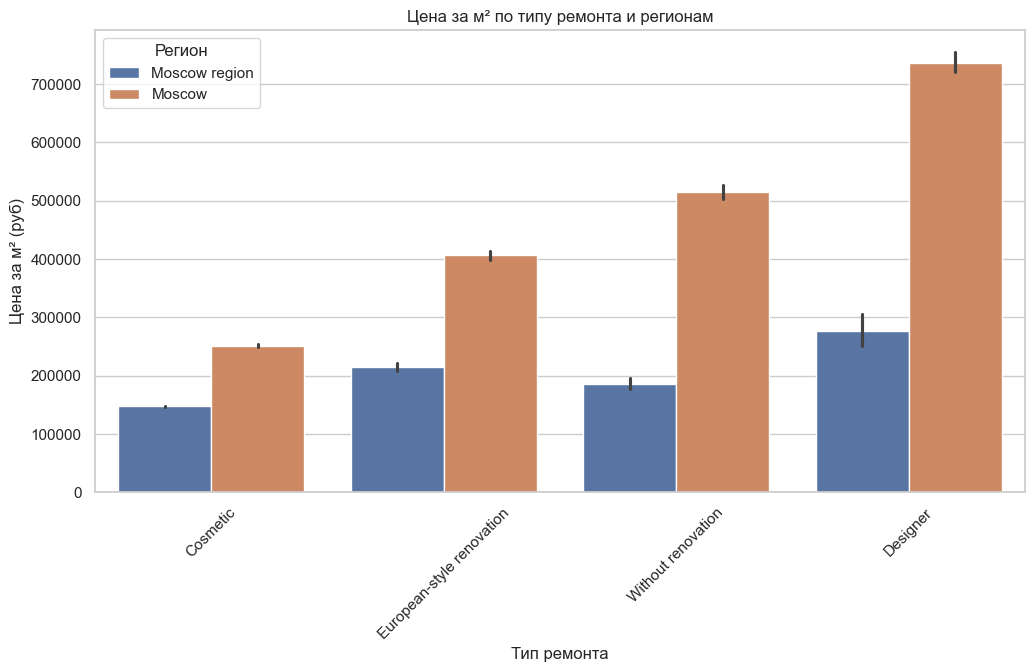

In [133]:
# Цена за м² по регионам и количеству комнат
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of rooms', y='Price per m²', hue='Region', data=df)
plt.title('Цена за м² по количеству комнат и регионам')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за м² (руб)')
plt.legend(title='Регион')
plt.show()

# Цена за м² по регионам и типу ремонта
plt.figure(figsize=(12, 6))
sns.barplot(x='Renovation', y='Price per m²', hue='Region', data=df)
plt.title('Цена за м² по типу ремонта и регионам')
plt.xlabel('Тип ремонта')
plt.ylabel('Цена за м² (руб)')
plt.xticks(rotation=45)
plt.legend(title='Регион')
plt.show()

In [136]:
# Разделяем данные по регионам
moscow = df[df['Region'] == 'Moscow']['Price per m²']
moscow_region = df[df['Region'] == 'Moscow region']['Price per m²']

# T-тест
t_stat, p_value = ttest_ind(moscow, moscow_region, equal_var=False)
print(f"T-статистика: {t_stat}, p-значение: {p_value}")

T-статистика: 102.90468880587106, p-значение: 0.0
